In [246]:
import numpy as np
import pandas as pd
from numpy import interp
from matplotlib import pyplot as plt

In [247]:
pd.set_option("display.max_columns", None)

In [248]:
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [249]:
from sklearn.metrics import plot_confusion_matrix, roc_auc_score,  auc, \
    precision_recall_fscore_support, classification_report, roc_curve, plot_roc_curve

In [250]:
from sklearn import set_config
set_config(display='diagram')   

In [251]:
from catboost import CatBoostClassifier

In [252]:

from itertools import cycle
from time import time

In [253]:
from lightgbm import LGBMClassifier

# Import data

In [254]:
df_train = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')

In [255]:
df_test = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')

In [256]:
sample_sub = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')

In [257]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


In [258]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C
...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
99996,199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
99997,199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S
99998,199998,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C


In [259]:
sample_sub

,PassengerId,Survived
0,100000,1
1,100001,1
2,100002,1
3,100003,1
4,100004,1
...,...,...
99995,199995,1
99996,199996,1
99997,199997,1
99998,199998,1


## Basic preprocess

In [260]:
X_train = df_train[[col for col in df_train.columns if col != 'Survived']]
X_train.columns = [c.lower() for c in X_train.columns]
X_train.set_index('passengerid', inplace=True)
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
0,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [261]:
y_train = df_train[['PassengerId','Survived']]
y_train.columns = [c.lower() for c in y_train.columns]
y_train.set_index('passengerid', inplace=True)
y_train = y_train['survived']
y_train.head()

passengerid
0    1
1    0
2    0
3    0
4    1
Name: survived, dtype: int64

In [262]:
X_test = df_test[[col for col in df_test.columns if col != 'Survived']]
X_test.columns = [c.lower() for c in X_test.columns]
X_test.set_index('passengerid', inplace=True)
X_test.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


## pipeline simple

In [263]:
text_features = ['name', 'ticket']
cat_features = ['sex', 'embarked', 'cabin']

In [264]:
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [265]:
original_features = X_train.columns.to_list()

In [266]:
def transform_name(df_base, col):
    df = df_base[col].apply(lambda x: x.split(',')).to_frame('list_name')
    df['surname'] = df['list_name'].apply(lambda x: x[0])
    df['forename'] = df['list_name'].apply(lambda x: x[1])
    return df[['surname', 'forename']]

In [267]:
def get_tck_str(tck):
    try:
        x = tck.split()
        try: 
            a = int(x[0])
            return None
        except:
            return x[0]
    except:
        return None
    
def get_tck_num(tck):
    try:
        x = tck.split()
        try:
            a = int(x[0])
            return a
        except:
            return None
    except:
        return None

def transform_ticket(df_base, col):
    df_ticket = df_base[col].to_frame('ticket')
    df_ticket['ticket_str'] = df_base[col].apply(get_tck_str)
    df_ticket['ticket_num'] = df_base[col].apply(get_tck_num)
    return df_ticket[['ticket_str', 'ticket_num']]

In [268]:
def transform_cabin(df_base, col):
    df_cabin = df_base[col].to_frame('cabin')
    df_cabin_clean = df_cabin[~df_cabin['cabin'].isna()].copy()
    df_cabin_clean['cabin_str'] = df_cabin_clean['cabin'].apply(lambda x: x[0])
    df_cabin_clean['cabin_num'] = df_cabin_clean['cabin'].apply(lambda x: x[1:]).astype(int)
    return df_cabin.join(df_cabin_clean[['cabin_str', 'cabin_num']])[['cabin_str', 'cabin_num']]

In [269]:
from sklearn.base import TransformerMixin, BaseEstimator
class PassNameTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_name(X, 'name')
        return self.X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()

class TicketTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_ticket(X, 'ticket')
        return self.X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()
    
class CabinTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_cabin(X, 'cabin')
        return self.X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        super(ColumnSelectTransformer).__init__()
        self.columns=columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

In [270]:
def lower_values(df):
    o_features = df.dtypes[df.dtypes=='object'].index.to_list()
    df_copy = df.copy()
    for c in o_features:
        df_copy[c] = df_copy[c].apply(lambda x: x.lower() if type(x)==str else None)
    return df_copy
class LowerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return lower_values(X)

In [271]:
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from tqdm.auto import tqdm

class featureUnion(FeatureUnion):
    def _hstack(self, Xs):
        cols = [X.columns.tolist() for X in Xs]
        dtypes = []
        for X in Xs:
            dtypes.append([str(X[col].dtype) for col in X])
        cols = np.hstack(cols)
        dtypes = np.hstack(dtypes)
        data = pd.DataFrame(super()._hstack(Xs), columns = cols)
        print('====Converting columns types====')
        for col, dtype in tqdm(zip(cols, dtypes)):
            data[col] = data[col].astype(dtype)
        return data

class columnTransformer(ColumnTransformer):
    def _hstack(self, Xs):
        cols = [X.columns.tolist() for X in Xs]
        dtypes = []
        print(cols)
        print([X.shape for X in Xs])
        for X in Xs:
            dtypes.append([str(X[col].dtype) for col in X])
        cols = np.hstack(cols)
        dtypes = np.hstack(dtypes)
        data = pd.DataFrame(super()._hstack(Xs), columns = cols)
        print('====Converting columns types====')
        for col, dtype in tqdm(zip(cols, dtypes)):
            data[col] = data[col].astype(dtype)
        return data

In [272]:
col_processor = featureUnion(transformer_list=[
    ('pass_name', PassNameTransformer()),
    ('ticket', TicketTransformer()),
    ('cabin', CabinTransformer()),
    ('others', ColumnSelectTransformer(columns=[c for c in original_features if c not in ('name', 'ticket', 'cabin')]))
]
)
pl = Pipeline(steps=[
    ('raw_data_processor', col_processor),
    ('lower_text_values', LowerTransformer())
])

In [273]:
pl

Pipeline(steps=[('raw_data_processor',
                 featureUnion(transformer_list=[('pass_name',
                                                 PassNameTransformer()),
                                                ('ticket', TicketTransformer()),
                                                ('cabin', CabinTransformer()),
                                                ('others',
                                                 ColumnSelectTransformer(columns=['pclass',
                                                                                  'sex',
                                                                                  'age',
                                                                                  'sibsp',
                                                                                  'parch',
                                                                                  'fare',
                                                                                  'embarked']))])),
                ('lower_text_values', LowerTransformer())])

In [274]:
df2 = pl.fit_transform(X_train)

====Converting columns types====


0it [00:00, ?it/s]

In [275]:
df2

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,oconnor,frankie,None,209245.0,c,12239.0,1,male,NaN,2,0,27.14,s
1,bryan,drew,None,27323.0,None,NaN,3,male,NaN,0,0,13.35,s
2,owens,kenneth,ca,NaN,None,NaN,3,male,0.33,1,2,71.29,s
3,kramer,james,a.,NaN,None,NaN,3,male,19.00,0,0,13.04,s
4,bond,michael,None,427635.0,None,NaN,3,male,25.00,0,0,7.76,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,bell,adele,pc,NaN,d,17243.0,2,female,62.00,0,0,14.86,c
99996,brown,herman,None,13273.0,None,NaN,2,male,66.00,0,0,11.15,s
99997,childress,charles,None,NaN,None,NaN,3,male,37.00,0,0,9.95,s
99998,caughlin,thomas,None,458654.0,None,NaN,3,male,51.00,0,1,30.92,s


In [276]:
from sklearn.impute import SimpleImputer

class simpleImputer(SimpleImputer):
    def fit(self, X, y=None):
        self._cols = X.columns.tolist()
        self._dtypes = [str(X[col].dtype) for col in X.columns]
        super().fit(X, y)
        return self
        
    def transform(self, X):
        X_ = super().transform(X)
        data = pd.DataFrame(X_, columns = self._cols)
        for col, dtype in tqdm(zip(self._cols, self._dtypes)):
            data[col] = data[col].astype(dtype)
        return data
        

In [277]:
col_handle_na = columnTransformer(
    transformers=[
        ('text_features', simpleImputer(missing_values=None, strategy='constant', fill_value='unk'), make_column_selector(dtype_include=['object'])),
        ('float_features', simpleImputer(strategy='median'), make_column_selector(dtype_include=['float64'])),
        ('count_features', simpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=['int64']))
    ],
    remainder='passthrough'
)

In [278]:
pl_simple = Pipeline(steps=[
    ('pl', pl),
    ('null_handling', col_handle_na)
])

In [279]:
pl_simple

Pipeline(steps=[('pl',
                 Pipeline(steps=[('raw_data_processor',
                                  featureUnion(transformer_list=[('pass_name',
                                                                  PassNameTransformer()),
                                                                 ('ticket',
                                                                  TicketTransformer()),
                                                                 ('cabin',
                                                                  CabinTransformer()),
                                                                 ('others',
                                                                  ColumnSelectTransformer(columns=['pclass',
                                                                                                   'sex',
                                                                                                   'age',
                                                                                                   'sibsp',
                                                                                                   'parch',
                                                                                                   'fare',
                                                                                                   'embarked']))])),
                                 ('lower_text_values', LowerTransformer())])),
                ('null_handling...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9a8814e9d0>),
                                                 ('float_features',
                                                  simpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9a8814ea50>),
                                                 ('count_features',
                                                  simpleImputer(strategy='most_frequent'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9a8814ead0>)]))])

In [280]:
df3 = pl_simple.fit_transform(X_train)

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

In [281]:
df3

,surname,forename,ticket_str,cabin_str,sex,embarked,ticket_num,cabin_num,age,fare,pclass,sibsp,parch
0,oconnor,frankie,unk,c,male,s,209245.0,12239.0,39.00,27.14,1,2,0
1,bryan,drew,unk,unk,male,s,27323.0,12603.5,39.00,13.35,3,0,0
2,owens,kenneth,ca,unk,male,s,39185.5,12603.5,0.33,71.29,3,1,2
3,kramer,james,a.,unk,male,s,39185.5,12603.5,19.00,13.04,3,0,0
4,bond,michael,unk,unk,male,s,427635.0,12603.5,25.00,7.76,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,bell,adele,pc,d,female,c,39185.5,17243.0,62.00,14.86,2,0,0
99996,brown,herman,unk,unk,male,s,13273.0,12603.5,66.00,11.15,2,0,0
99997,childress,charles,unk,unk,male,s,39185.5,12603.5,37.00,9.95,3,0,0
99998,caughlin,thomas,unk,unk,male,s,458654.0,12603.5,51.00,30.92,3,0,1


In [282]:
class PipelineLogger(object):
    def __init__(self):
        pass
        
    def log_start(self):
        self.start_time = time()
        print(f'======== {self.__class__.__name__} - START ========')
        return None
        
    def log_finish(self):
        self.duration = time() - self.start_time
        print(f'======== {self.__class__.__name__} - FINISH =======> Take: {self.duration:.6f}(s)')


class ExperimentBase(BaseEstimator):
    def evaluate(self, X_test, y_test):
        print('Evaluating model')
        print(classification_report(y_true=y_test, y_pred=self.predict(X_test)))
        metrics = self.auc_report(X_test, y_test)
        metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['support'] = precision_recall_fscore_support(y_test, self.predict(X_test))
        return metrics
    
    def auc_report(self, X, y_true):
        classes = self.classes_
        y_pred_classes = self.predict_proba(X)
        n_classes = len(classes)

        lw = 2
        for i in range(len(classes)):
            print(f"""{classes[i]}: {roc_auc_score(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])}""")

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(classes[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()
        metrics = {
            'macro_auc': roc_auc["macro"]
        }
        for i in range(n_classes):
            metrics[f'auc_{classes[i]}'] = roc_auc[i]
        return metrics


In [283]:
class CustomCatBoostClassifier(CatBoostClassifier, ExperimentBase, PipelineLogger):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def fit(self, X, y, self_evaluate=True, **kwargs):
        self.log_start()
        if self._init_params.get('cat_features') is not None:
            cat_features_ = [c for c in self._init_params['cat_features'] if c in X.columns]
            self._init_params['cat_features'] = cat_features_
        else:
            cat_features_ = None
        if self._init_params.get('text_features') is not None:
            text_features_ = [c for c in self._init_params['text_features'] if c in X.columns]
            self._init_params['text_features'] = text_features_
        else:
            text_features_ = None
        
        X_t, X_e, y_t, y_e = self.train_eval_split(X, y, cat_features_, text_features_)
        super().fit(X_t, y_t, eval_set=(X_e, y_e), cat_features=cat_features_, text_features=text_features_)
        if self_evaluate:
            _ = self.evaluate(X_e, y_e)
        self.log_finish()
        return self
        
    def train_eval_split(self, X, y, cat_features_, text_features_, eval_frac=0.1, add_na_Xy=False, na_label=0):
        X_e = X.sample(frac=eval_frac, random_state=42)
        y_e = y.loc[X_e.index]
        X_t = X.drop(X_e.index)
        y_t = y.loc[X_t.index]
        if add_na_Xy:
            X_t = pd.concat([X_t, pd.DataFrame([[np.nan] * X_t.shape[1]], columns=X_t.columns)], ignore_index=True)
            y_t = pd.concat([y_t, pd.Series([na_label])], ignore_index=True)
        if cat_features_ is not None:
            cat_features_ = [c for c in cat_features_ if c in X.columns]
            X_t[cat_features_] = X_t[cat_features_].fillna('unk')
            X_e[cat_features_] = X_e[cat_features_].fillna('unk')
        if text_features_ is not None:
            text_features_ = [c for c in text_features_ if c in X.columns]
            X_t[text_features_] = X_t[text_features_].fillna('unk')
            X_e[text_features_] = X_e[text_features_].fillna('unk')
        
        return X_t, X_e, y_t, y_e


In [284]:
df3.head(2)

,surname,forename,ticket_str,cabin_str,sex,embarked,ticket_num,cabin_num,age,fare,pclass,sibsp,parch
0,oconnor,frankie,unk,c,male,s,209245.0,12239.0,39.0,27.14,1,2,0
1,bryan,drew,unk,unk,male,s,27323.0,12603.5,39.0,13.35,3,0,0


In [285]:
cat_features = ['ticket_str', 'cabin_str', 'embarked', 'sex'] + ['surname', 'forename']
# text_features = 
cb_cfg = {
    'iterations': 1000,
    'task_type': 'CPU',
    'cat_features': cat_features,
#     'text_features': text_features,
    'use_best_model': True,
    'early_stopping_rounds':50,
    'verbose': True,
    'metric_period': 25
}

In [286]:
pl4 = Pipeline(steps=[
    ('pl_simple', pl_simple),
    ('catboost_simple', CustomCatBoostClassifier(**cb_cfg))
])
pl4

Pipeline(steps=[('pl_simple',
                 Pipeline(steps=[('pl',
                                  Pipeline(steps=[('raw_data_processor',
                                                   featureUnion(transformer_list=[('pass_name',
                                                                                   PassNameTransformer()),
                                                                                  ('ticket',
                                                                                   TicketTransformer()),
                                                                                  ('cabin',
                                                                                   CabinTransformer()),
                                                                                  ('others',
                                                                                   ColumnSelectTransformer(columns=['pclass',
                                                                                                                    'sex',
                                                                                                                    'age',
                                                                                                                    'sibsp',
                                                                                                                    'parch',
                                                                                                                    'fare',
                                                                                                                    'embarked']))])),
                                                  ('lower_text_values',
                                                   LowerTran...
                                                                   simpleImputer(strategy='most_frequent'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f9a8814ead0>)]))])),
                ('catboost_simple',
                 CustomCatBoostClassifier(cat_features=['ticket_str',
                                                        'cabin_str', 'embarked',
                                                        'sex', 'surname',
                                                        'forename'],
                                          early_stopping_rounds=50,
                                          iterations=1000, metric_period=25,
                                          task_type='CPU', use_best_model=True,
                                          verbose=True))])

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

======== CustomCatBoostClassifier - START ========
Learning rate set to 0.096296
0:	learn: 0.6509106	test: 0.6500870	best: 0.6500870 (0)	total: 91.8ms	remaining: 1m 31s


25:	learn: 0.4771816	test: 0.4732935	best: 0.4732935 (25)	total: 1.74s	remaining: 1m 5s
50:	learn: 0.4697525	test: 0.4668532	best: 0.4668532 (50)	total: 3.59s	remaining: 1m 6s
75:	learn: 0.4669314	test: 0.4651706	best: 0.4651706 (75)	total: 5.42s	remaining: 1m 5s
100:	learn: 0.4650181	test: 0.4643460	best: 0.4643238 (99)	total: 7.25s	remaining: 1m 4s
125:	learn: 0.4631222	test: 0.4637807	best: 0.4637527 (123)	total: 9.01s	remaining: 1m 2s
150:	learn: 0.4606853	test: 0.4627402	best: 0.4627402 (150)	total: 10.9s	remaining: 1m 1s
175:	learn: 0.4592878	test: 0.4622651	best: 0.4622533 (174)	total: 12.8s	remaining: 59.8s
200:	learn: 0.4579564	test: 0.4619557	best: 0.4619557 (200)	total: 14.8s	remaining: 58.7s
225:	learn: 0.4568762	test: 0.4619415	best: 0.4619334 (224)	total: 16.7s	remaining: 57.1s
250:	learn: 0.4558493	test: 0.4620429	best: 0.4619334 (224)	total: 18.5s	remaining: 55.2s
275:	learn: 0.4546970	test: 0.4619447	best: 0.4618932 (266)	total: 20.3s	remaining: 53.3s
300:	learn: 0.453

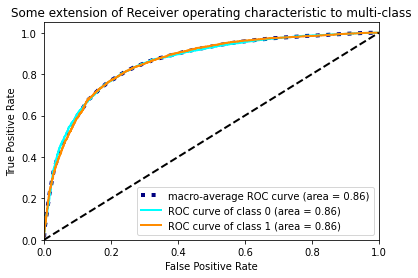

======== CustomCatBoostClassifier - FINISH =======> Take: 25.811851(s)


Pipeline(steps=[('pl_simple',
                 Pipeline(steps=[('pl',
                                  Pipeline(steps=[('raw_data_processor',
                                                   featureUnion(transformer_list=[('pass_name',
                                                                                   PassNameTransformer()),
                                                                                  ('ticket',
                                                                                   TicketTransformer()),
                                                                                  ('cabin',
                                                                                   CabinTransformer()),
                                                                                  ('others',
                                                                                   ColumnSelectTransformer(columns=['pclass',
                                                                                                                    'sex',
                                                                                                                    'age',
                                                                                                                    'sibsp',
                                                                                                                    'parch',
                                                                                                                    'fare',
                                                                                                                    'embarked']))])),
                                                  ('lower_text_values',
                                                   LowerTran...
                                                                   simpleImputer(strategy='most_frequent'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f9a8814ead0>)]))])),
                ('catboost_simple',
                 CustomCatBoostClassifier(cat_features=['ticket_str',
                                                        'cabin_str', 'embarked',
                                                        'sex', 'surname',
                                                        'forename'],
                                          early_stopping_rounds=50,
                                          iterations=1000, metric_period=25,
                                          task_type='CPU', use_best_model=True,
                                          verbose=True))])

In [317]:
pl4.fit(X_train, y_train)

In [318]:
b = pl4.predict(X_test)

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

In [289]:
df2[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked']]

,surname,forename,ticket_str,cabin_str,sex,embarked
0,oconnor,frankie,None,c,male,s
1,bryan,drew,None,None,male,s
2,owens,kenneth,ca,None,male,s
3,kramer,james,a.,None,male,s
4,bond,michael,None,None,male,s
...,...,...,...,...,...,...
99995,bell,adele,pc,d,female,c
99996,brown,herman,None,None,male,s
99997,childress,charles,None,None,male,s
99998,caughlin,thomas,None,None,male,s


In [298]:
from sklearn.preprocessing import LabelEncoder
class CustomLabelEncoder(PipelineLogger,TransformerMixin, BaseEstimator):
    def __init__(self, columns=None):
        super(CustomLabelEncoder).__init__()
        self.columns = columns
        self.label_encoders = {}
        
    def fit(self, X, y=None):
        X_ = X[self.columns]
        X_ = pd.concat([X_, pd.DataFrame([['unk'] * X_.shape[1]], columns=X_.columns)], ignore_index=True)
        for c in self.columns:
            self.label_encoders[c] = LabelEncoder().fit(X_[c])
        print(self.label_encoders)
        return self
    
    def transform(self, X, y=None):
        X_ = pd.DataFrame()
        self.dummy_dicts = {}
        for c in self.columns:
            dd = {}
            for cl in self.label_encoders[c].classes_:
                dd[cl] = True
            sr = X[c].map(lambda s: 'unk' if dd.get(s) is None else s)
            X_[c] = self.label_encoders[c].transform(sr)
        return X_
            
    def inverse_transform(self, X_encode, y=None):
        X_decode = pd.DataFrame()
        for c in self.columns:
            X_decode[c] = self.label_encoders[c].inverse_transform(X_encode[c])
        return X_decode

In [299]:
mul_le = CustomLabelEncoder(
        columns=['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked']
)

In [300]:
label_encoding = columnTransformer(transformers=[
    ('category_encoder', mul_le, ['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'])
], remainder='passthrough')

In [301]:
mul_le.fit_transform(df2)

{'surname': LabelEncoder(), 'forename': LabelEncoder(), 'ticket_str': LabelEncoder(), 'cabin_str': LabelEncoder(), 'sex': LabelEncoder(), 'embarked': LabelEncoder()}


,surname,forename,ticket_str,cabin_str,sex,embarked
0,14195,1311,49,2,1,2
1,2495,1015,49,9,1,2
2,14478,2010,14,9,1,2
3,10435,1662,0,9,1,2
4,1902,2678,49,9,1,2
...,...,...,...,...,...,...
99995,1301,18,21,3,0,0
99996,2436,1507,49,9,1,2
99997,3463,610,49,9,1,2
99998,3226,3636,49,9,1,2


In [302]:
df2

,surname,forename,ticket_str,ticket_num,cabin_str,cabin_num,pclass,sex,age,sibsp,parch,fare,embarked
0,oconnor,frankie,None,209245.0,c,12239.0,1,male,NaN,2,0,27.14,s
1,bryan,drew,None,27323.0,None,NaN,3,male,NaN,0,0,13.35,s
2,owens,kenneth,ca,NaN,None,NaN,3,male,0.33,1,2,71.29,s
3,kramer,james,a.,NaN,None,NaN,3,male,19.00,0,0,13.04,s
4,bond,michael,None,427635.0,None,NaN,3,male,25.00,0,0,7.76,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,bell,adele,pc,NaN,d,17243.0,2,female,62.00,0,0,14.86,c
99996,brown,herman,None,13273.0,None,NaN,2,male,66.00,0,0,11.15,s
99997,childress,charles,None,NaN,None,NaN,3,male,37.00,0,0,9.95,s
99998,caughlin,thomas,None,458654.0,None,NaN,3,male,51.00,0,1,30.92,s


In [306]:
class CustomLGBMClassifier(ExperimentBase, LGBMClassifier):
    pass

In [307]:
pl_lgbm = Pipeline(steps=[
    ('prepro', pl),
    ('label_encoding', label_encoding),
    ('lgbm', CustomLGBMClassifier())
])

In [308]:
pl_lgbm.fit(X_train, y_train)

====Converting columns types====


0it [00:00, ?it/s]

{'surname': LabelEncoder(), 'forename': LabelEncoder(), 'ticket_str': LabelEncoder(), 'cabin_str': LabelEncoder(), 'sex': LabelEncoder(), 'embarked': LabelEncoder()}
[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'pclass', 'age', 'sibsp', 'parch', 'fare']]
[(100000, 6), (100000, 7)]
====Converting columns types====


0it [00:00, ?it/s]

Pipeline(steps=[('prepro',
                 Pipeline(steps=[('raw_data_processor',
                                  featureUnion(transformer_list=[('pass_name',
                                                                  PassNameTransformer()),
                                                                 ('ticket',
                                                                  TicketTransformer()),
                                                                 ('cabin',
                                                                  CabinTransformer()),
                                                                 ('others',
                                                                  ColumnSelectTransformer(columns=['pclass',
                                                                                                   'sex',
                                                                                                   'age',
                                                                                                   'sibsp',
                                                                                                   'parch',
                                                                                                   'fare',
                                                                                                   'embarked']))])),
                                 ('lower_text_values', LowerTransformer())])),
                ('label_encoding',
                 columnTransformer(remainder='passthrough',
                                   transformers=[('category_encoder',
                                                  CustomLabelEncoder(columns=['surname',
                                                                              'forename',
                                                                              'ticket_str',
                                                                              'cabin_str',
                                                                              'sex',
                                                                              'embarked']),
                                                  ['surname', 'forename',
                                                   'ticket_str', 'cabin_str',
                                                   'sex', 'embarked'])])),
                ('lgbm', CustomLGBMClassifier())])

In [309]:
pl_lgbm.predict(X_test)

====Converting columns types====


0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'pclass', 'age', 'sibsp', 'parch', 'fare']]
[(100000, 6), (100000, 7)]
====Converting columns types====


0it [00:00, ?it/s]

array([0, 0, 1, ..., 0, 1, 1])

In [320]:
a = pl_lgbm.predict(X_train)

====Converting columns types====


0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'pclass', 'age', 'sibsp', 'parch', 'fare']]
[(100000, 6), (100000, 7)]
====Converting columns types====


0it [00:00, ?it/s]

In [324]:
print(classification_report(y_train, a))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     57226
           1       0.77      0.74      0.75     42774

    accuracy                           0.79    100000
   macro avg       0.79      0.79      0.79    100000
weighted avg       0.79      0.79      0.79    100000



In [322]:
a

array([0, 0, 0, ..., 0, 0, 0])

In [325]:
b = pl4.predict(X_train)

====Converting columns types====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], ['ticket_num', 'cabin_num', 'age', 'fare'], ['pclass', 'sibsp', 'parch']]
[(100000, 6), (100000, 4), (100000, 3)]
====Converting columns types====


0it [00:00, ?it/s]

In [326]:
b

array([0, 0, 0, ..., 0, 0, 0])

In [329]:
(~(a == b)).sum()

2396

In [ ]:
from catboost import CatBoostRegressor, CatBoostClassifier

In [ ]:
def fill_unk(sr):
    return sr.fillna('unk')

In [ ]:
def fill_mean(sr):
    return sr.fillna(sr.mean())

In [ ]:
def fill_0(sr):
    return sr.fillna(0)

In [ ]:
def fill_popular(sr):
    popular = sr.value_counts().index[0]
    return sr.fillna(popular)

In [ ]:
((df2['ticket_str'].value_counts().max() / df2['ticket_str'].value_counts()) ** 0.3).to_dict()

In [ ]:
((df2['cabin_str'].value_counts().max() / df2['cabin_str'].value_counts()) ** 0.3).to_dict()

In [ ]:
impute_plan = {
    'features_plan': {
        'fare': {
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['fare']],
            'catboost_kwgs': {'iterations':200}
        },
        'embarked': {
            'model': CatBoostClassifier,
            'predictors': [c for c in df2.columns if c not in ['embarked']],
            'catboost_kwgs': {'iterations': 200}
        },
        'age': {
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['age']],
            'catboost_kwgs': {'iterations': 200}
        },
        'ticket_num':{
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['age']],
            'catboost_kwgs': {'iterations': 200}
        },
        'ticket_str':{
            'model': CatBoostClassifier,
            'predictors': [c for c in df2.columns if c not in ['embarked']],
            'catboost_kwgs': {
                'iterations': 200, 
                'class_weights': ((df2['ticket_str'].value_counts().max() / df2['ticket_str'].value_counts()) ** 0.3).to_dict()
            }
        },
        'cabin_num':{
            'model': CatBoostRegressor,
            'predictors': [c for c in df2.columns if c not in ['age']],
            'catboost_kwgs': {
                'iterations': 200
            }
        },
        'cabin_str':{
            'model': CatBoostClassifier,
            'predictors': [c for c in df2.columns if c not in ['embarked']],
            'catboost_kwgs': {
                'iterations': 200,
                'class_weights': ((df2['cabin_str'].value_counts().max() / df2['cabin_str'].value_counts()) ** 0.3).to_dict()
            }
        }
    },
    'if_na': {
        'ticket_str':fill_unk,
        'ticket_num':fill_mean,
        'cabin_str':fill_unk,
        'cabin_num':fill_mean,
        'age':fill_mean,
        'embarked':fill_popular,
        'fare': fill_mean
    },
    'eval_frac': 0.1,
    'cat_features': ['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked']
}

In [ ]:
from sklearn.model_selection import train_test_split

class CatBoostImputor(BaseEstimator, TransformerMixin):
    def __init__(self, impute_plan, predictors_order):
        super(CatBoostImputor).__init__()
        self.impute_plan = impute_plan
        self.predictors_order = predictors_order
        
    def fit(self, X, y=None):
        return self
    
    def train_eval_test_split(self, x, y):
        eval_frac = self.impute_plan['eval_frac']
        y_test = y[y.isna()].copy()
        x_test = x[y.isna()].copy()
        x_t = x[~y.isna()].copy()
        y_t = y[~y.isna()].copy()
        x_train, x_eval, y_train, y_eval = train_test_split(x_t, y_t, test_size=eval_frac)
        return x_train, y_train, x_eval, y_eval, x_test, y_test
        
    def transform(self, X):
        self.X = X
        self.X_impute = X.copy()
        for col in self.predictors_order:
            predictor_list = self.impute_plan['features_plan'][col]['predictors']
            cat_features=[c for c in predictor_list if c in self.impute_plan['cat_features']]
            # Prepare data to fit
            print(f'Prepare data to fit, feature: {col}')
            x = self.X_impute[predictor_list].copy()
            y = self.X_impute[col]
            na_cols = [col for col in x.columns if x[col].isna().sum() > 0]
            for c in na_cols:
                x[c] = self.impute_plan['if_na'][c](x[c])
            x_train, y_train, x_eval, y_eval, x_test, y_test = self.train_eval_test_split(x, y)
            
            # Create model
            ModelClass = self.impute_plan['features_plan'][col]['model']
            model = ModelClass(**self.impute_plan['features_plan'][col]['catboost_kwgs'], early_stopping_rounds=50, verbose=True, metric_period=50, use_best_model=True)
            # Fit model
            print(f'Fit model: {col}')
            model.fit(x_train, y_train, eval_set=(x_eval, y_eval), cat_features=cat_features)
            x_test[col] = model.predict(x_test)
            print(f'Predicted for {x_test.shape[0]} unknown examples')
            self.X_impute.loc[y.isna(),col] = x_test[col]
            print(f'Imputed done for {col}')
        print(f'Imputed done for all dataset, num null left: {self.X_impute.isna().sum()}')
        return self.X_impute
            
            

In [ ]:
cbi = CatBoostImputor(impute_plan, ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str'])

In [ ]:
clean_X_train = cbi.fit_transform(df2)

In [ ]:
print('Done')

In [ ]:
clean_X_train.to_parquet('data/clean_X_train.parquet')

In [ ]:
y_train

In [ ]:
X_train_t, X_train_e, y_train_t, y_train_e = train_test_split(clean_X_train, y_train, test_size=0.1)

In [ ]:
model_clean = CatBoostClassifier(iterations=1000, cat_features=['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], 
                                 early_stopping_rounds=50, verbose=True, metric_period=50, use_best_model=True)

In [ ]:
X_train_t

In [ ]:
model_clean.fit(X_train_t, y_train_t, eval_set = (X_train_e, y_train_e))

In [ ]:
y_train_e_pred = model_clean.predict(X_train_e)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train_e, model_clean.predict(X_train_e)))

In [ ]:
print(classification_report(y_train_t, model_clean.predict(X_train_t)))

In [ ]:
def ft_imp(model):
    fi = pd.DataFrame({
        'feature':X_train_e.columns,
        'importance': model.feature_importances_
    })

    return fi.sort_values(by='importance',ascending=False).iloc[:50].style.bar()

In [ ]:
ft_imp(model_clean)

In [ ]:
X_test_2 = pl.fit_transform(X_test)

In [ ]:
X_test_2

In [ ]:
cbi_test = CatBoostImputor(impute_plan, ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str'])

In [ ]:
X_test_clean = cbi_test.fit_transform(X_test_2)

In [ ]:
X_test_clean.to_parquet('data/clean_X_test.parquet')

In [ ]:
X_test_2.ticket_num.hist(bins=50)
plt.show()
X_test_clean.ticket_num.hist(bins=50)
plt.show()

In [ ]:
X_test_2.cabin_num.hist(bins=50)
plt.show()
X_test_clean.cabin_num.hist(bins=50)
plt.show()

In [ ]:
X_test_2.age.hist(bins=50)
plt.show()
X_test_clean.age.hist(bins=50)
plt.show()

In [ ]:
X_test_2.cabin_str.value_counts()[:20]

In [ ]:
X_test_clean.cabin_str.value_counts()[:20]

## Extent pipeline

In [ ]:
pl

In [ ]:
from copy import deepcopy

In [ ]:
impute_plan2 = deepcopy(impute_plan)
wgt = 0
impute_plan2['features_plan']['ticket_str']['catboost_kwgs']['class_weights'] = ((df2['ticket_str'].value_counts().max() / df2['ticket_str'].value_counts()) ** wgt).to_dict()
impute_plan2['features_plan']['cabin_str']['catboost_kwgs']['class_weights'] = ((df2['cabin_str'].value_counts().max() / df2['cabin_str'].value_counts()) ** wgt).to_dict()

In [ ]:
pl3 = Pipeline(steps = [
    ('aaa', pl), 
    ('catboost_imputor', CatBoostImputor(impute_plan2,  ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str']))
])

In [ ]:
pl3

In [ ]:
pl2 = Pipeline(steps=[
    ('raw_data_processor', col_processor),
    ('lower_text_values', LowerTransformer()),
    ('catboost_imputor', CatBoostImputor(impute_plan2,  ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str']))
])

In [ ]:
pl2

In [ ]:
clean_X_train2 = pl2.fit_transform(X_train)

In [ ]:
pl2.__class__.__name__

In [ ]:
a = CatBoostImputor(impute_plan, predictors_order=['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str'])

In [ ]:
a.__name__

In [ ]:
a.__class__.__name__

In [ ]:
a.__class__.__name__

In [ ]:
CatBoostImputor.__name__

In [ ]:
from time import time

In [ ]:
time()

In [ ]:
from time import time, sleep
class PipelineLogger:
    def __init__(self):
        pass
        
    def log_start(self):
        self.start_time = time()
        print(f'======== {self.__class__.__name__} - START ========')
        return None
        
    def log_finish(self):
        self.duration = time() - self.start_time
        print(f'======== {self.__class__.__name__} - FINISH =======> Take: {self.duration:.6f}(s)')

In [ ]:
class JustSleep(PipelineLogger):
    def __init__(self):
        pass
    
    def sleep(self):
        self.log_start()
        sleep(1)
        self.log_finish()

In [ ]:
js = JustSleep()

In [ ]:
js.sleep()

In [ ]:
pl += Pipeline(steps=[('catboost_imputor', CatBoostImputor(impute_plan,  ['fare', 'embarked', 'age', 'ticket_num', 'ticket_str', 'cabin_num', 'cabin_str']))])

# Catboost without fillna

In [ ]:
df2

In [ ]:
y_train

In [ ]:
y_train.value_counts()

In [ ]:
df2.info()

In [ ]:
X_train_fillsimple = df2.copy()
X_train_fillsimple[['ticket_str', 'cabin_str', 'embarked']] = X_train_fillsimple[['ticket_str', 'cabin_str', 'embarked']].fillna('unk')

In [ ]:
X_train_fs_t, X_train_fs_e, y_train_fs_t, y_train_fs_e = train_test_split(X_train_fillsimple, y_train, test_size=0.1)

In [ ]:
model_fs = CatBoostClassifier(iterations=1000, cat_features=['surname', 'forename', 'ticket_str', 'cabin_str', 'sex', 'embarked'], 
                                 early_stopping_rounds=50, verbose=True, metric_period=50, use_best_model=True, auto_class_weights=None)

In [ ]:
model_fs.fit(X_train_fs_t, y_train_fs_t, eval_set = (X_train_fs_e, y_train_fs_e), )

In [ ]:
X_test_fillsimple = X_test_2.copy()
X_test_fillsimple[['ticket_str', 'cabin_str', 'embarked']] = X_test_fillsimple[['ticket_str', 'cabin_str', 'embarked']].fillna('unk')

In [ ]:
print(classification_report(y_train_fs_t, model_fs.predict(X_train_fs_t)))

In [ ]:
print(classification_report(y_train_fs_e, model_fs.predict(X_train_fs_e)))

In [ ]:
X_test_fillsimple

In [ ]:
ft_imp(model_fs)

# Submit

## Model based on catboost imputed data

In [ ]:
X_test['Survived'] = model_clean.predict(X_test_clean)

In [ ]:
X_test

In [ ]:
m = X_test['Survived'].to_frame().reset_index()
m.columns = ['PassengerId', 'Survived']

In [ ]:
m.to_csv('submission/v1.csv', index=False)

# Model based on simple imputed data

In [ ]:
X_test['Survived_0_2'] = model_fs.predict(X_test_fillsimple)
m = X_test['Survived_0_2'].to_frame().reset_index()
m.columns = ['PassengerId', 'Survived']
m.to_csv('submission/v0_2.csv', index=False)